Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 963      |
|    ep_rew_mean     | -29.4    |
| time/              |          |
|    fps             | 2739     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 963         |
|    ep_rew_mean          | -31.9       |
| time/                   |             |
|    fps                  | 2205        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009280685 |
|    clip_fraction        | 0.0649      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0562      |
|    learning

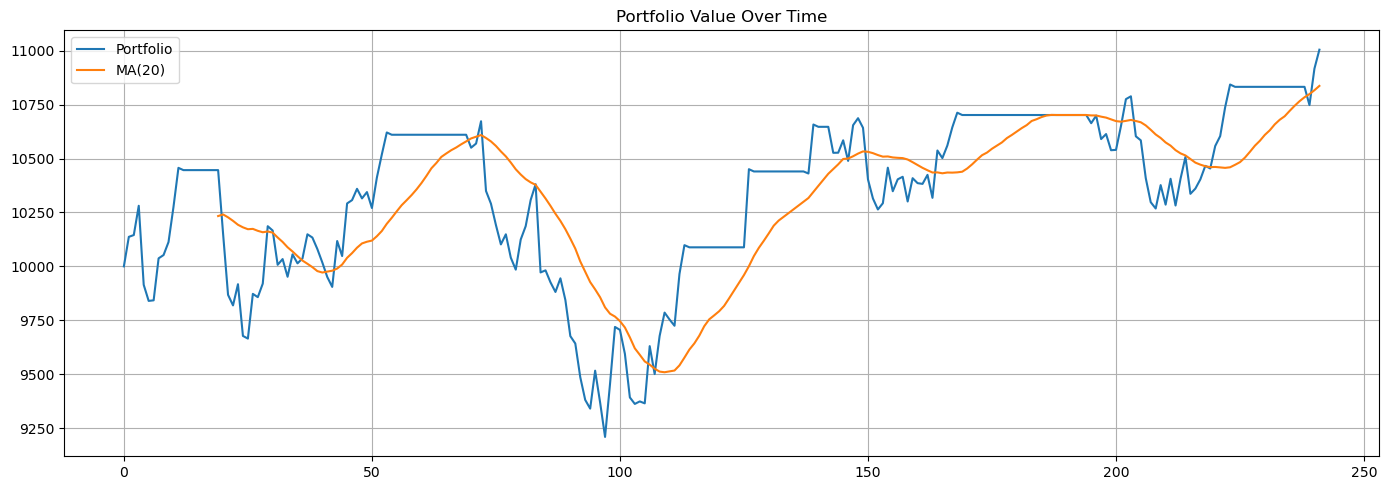

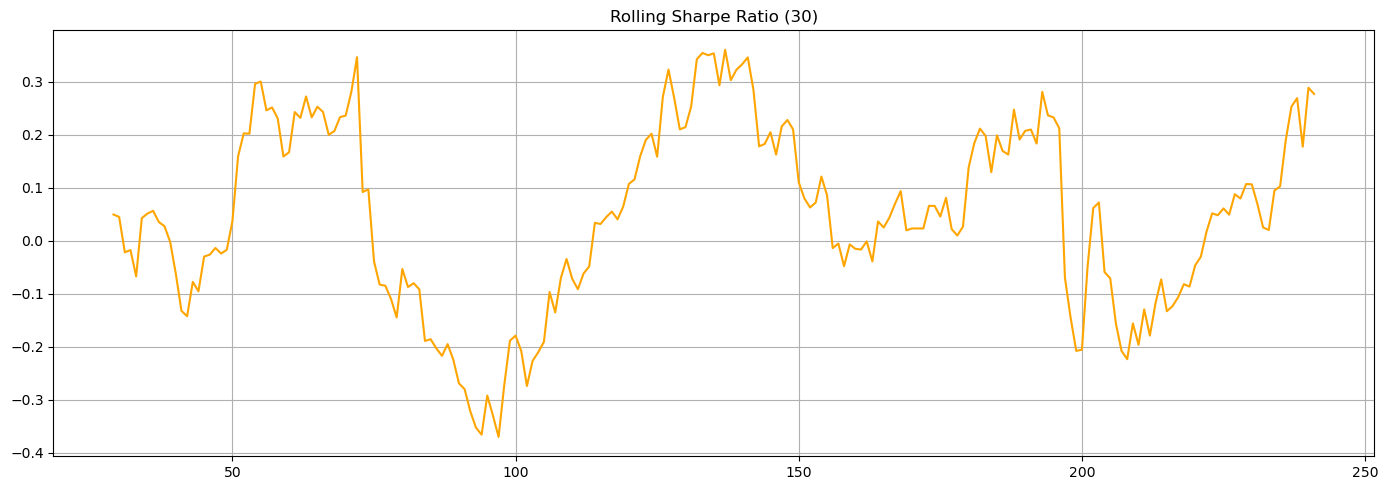

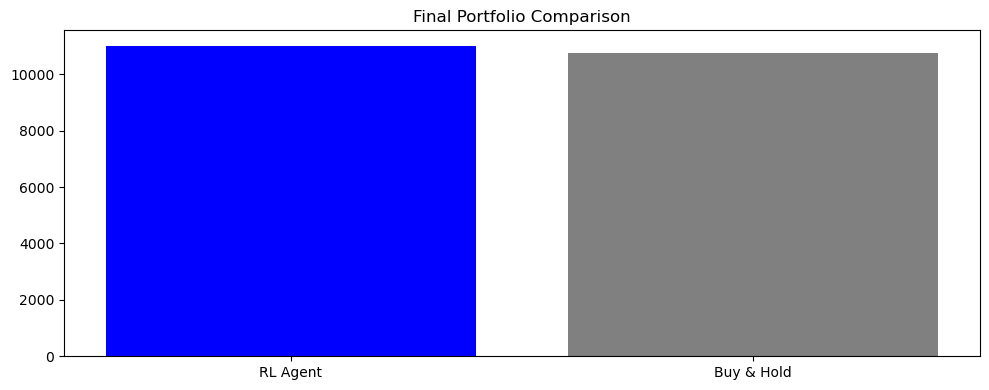

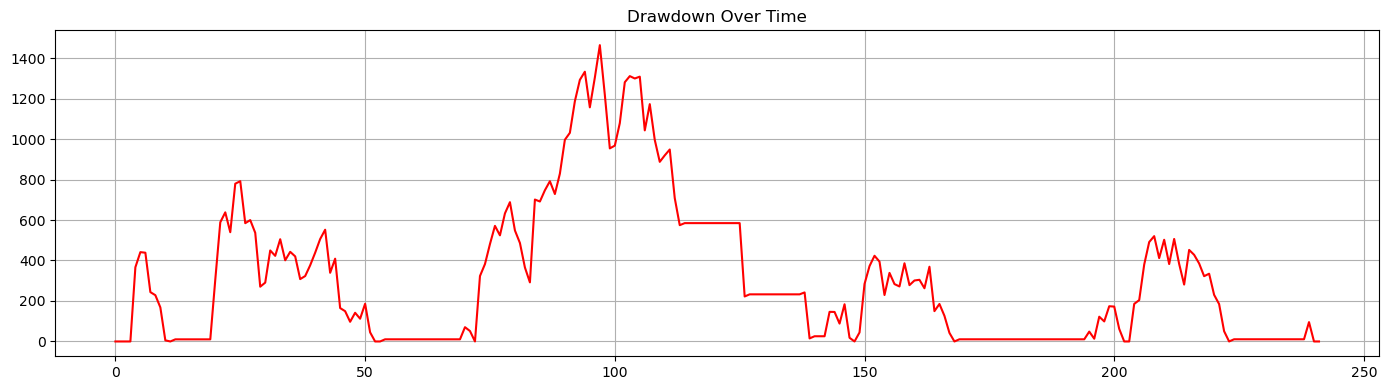

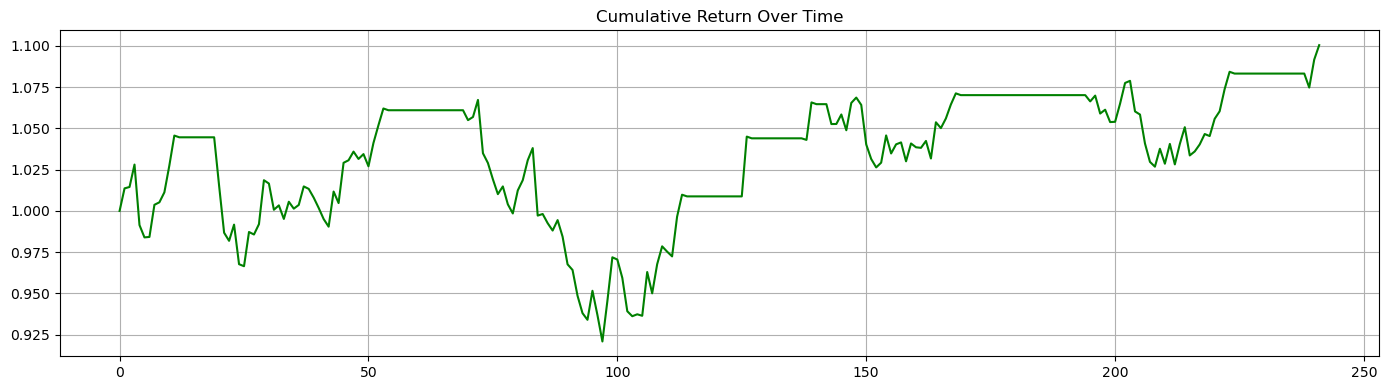

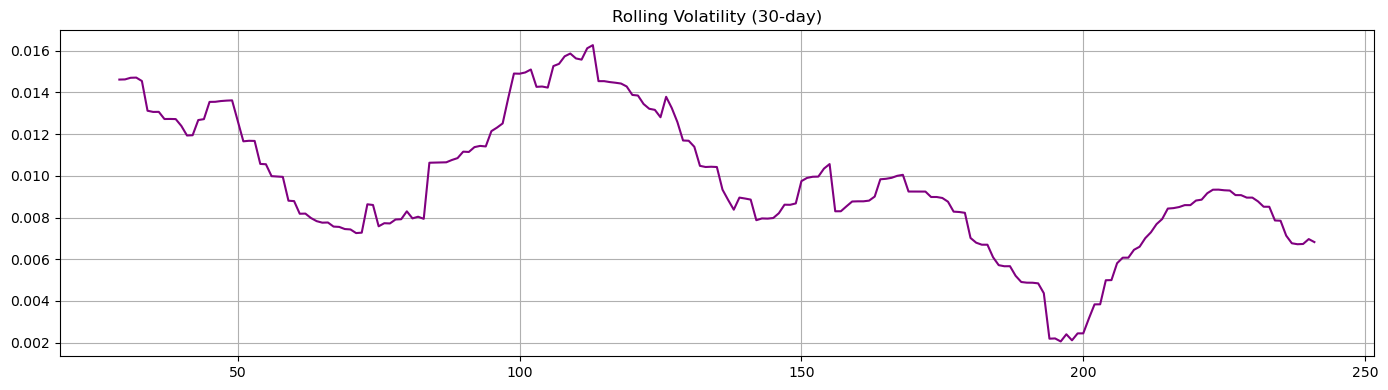

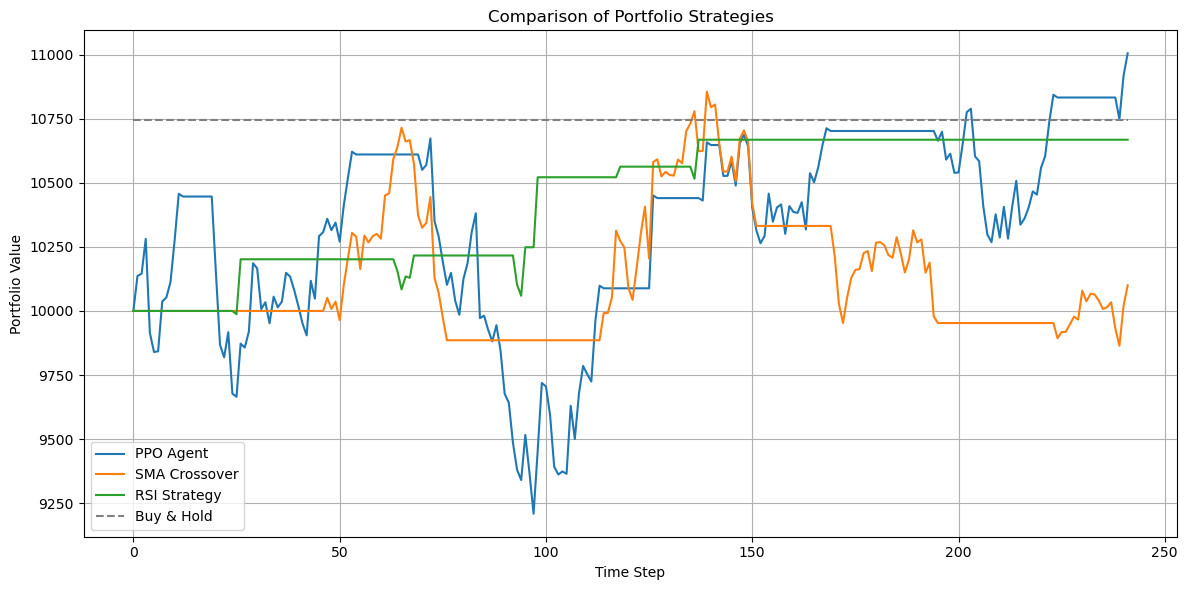


 Final Evaluation Summary:
Sharpe Ratio: 0.697
Final Portfolio Value: 11004.84
Buy & Hold Value: 10746.25
Max Drawdown: 1463.89
SMA Crossover Value: 10100.05
RSI Strategy Value: 10667.88
Buy Actions: 122
Sell Actions: 91


In [2]:
import os, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, StochRSIIndicator
from ta.volatility import BollingerBands

timestamp = time.strftime("%Y%m%d_%H%M%S")
save_dir = f"ppo_trading_model_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

# --- [Load & Preprocess Data] ---
df = pd.read_csv("cleaned_yahoo_data.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)

df["sma"] = SMAIndicator(df["Adj_Close"], window=14).sma_indicator()
df["rsi"] = RSIIndicator(df["Adj_Close"], window=14).rsi()
df["stoch_k"] = StochasticOscillator(df["High"], df["Low"], df["Close"]).stoch()
macd = MACD(df["Adj_Close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()
bb = BollingerBands(df["Adj_Close"])
df["bb_bbm"] = bb.bollinger_mavg()
df["bb_bbh"] = bb.bollinger_hband()
df["bb_bbl"] = bb.bollinger_lband()
df["ema_fast"] = EMAIndicator(df["Adj_Close"], window=10).ema_indicator()
df["ema_slow"] = EMAIndicator(df["Adj_Close"], window=30).ema_indicator()
df["adx"] = ADXIndicator(df["High"], df["Low"], df["Close"]).adx()
df["stoch_rsi"] = StochRSIIndicator(df["Adj_Close"]).stochrsi()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

excluded = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj_Close']
feature_columns = [col for col in df.columns if col not in excluded]
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])
df["daily_return"] = df["Adj_Close"].pct_change()
df["volatility_5"] = df["daily_return"].rolling(5).std()
df["volume_zscore"] = (df["Volume"] - df["Volume"].rolling(20).mean()) / df["Volume"].rolling(20).std()
df.dropna(inplace=True)

# --- [Train-Test Split] ---
split = int(0.8 * len(df))
df_train, df_test = df.iloc[:split], df.iloc[split:]

# --- [Custom PPO Gym Environment] ---
class PPOTradingEnv(gym.Env):
    def __init__(self, df, feature_columns):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.feature_columns = feature_columns
        self.initial_balance = 10000.0
        self.transaction_fee = 0.001
        self.stop_loss_threshold = 0.94
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(feature_columns)+2,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_held = 0.0
        self.total_asset = self.initial_balance
        self.asset_memory = [self.initial_balance]
        self.actions = []
        self.last_buy_price = 0.0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.iloc[self.current_step][self.feature_columns]
        obs = np.append(row.values, [self.balance / 10000, self.stock_held])
        return obs.astype(np.float32)

    def step(self, action):
        terminated = self.current_step >= len(self.df) - 2
        truncated = False
        price = self.df.iloc[self.current_step]["Adj_Close"]
        self.actions.append(action)

        reward = 0
        if action == 1 and self.stock_held == 0:
            shares = self.balance / (price * (1 + self.transaction_fee))
            self.stock_held += shares
            self.balance -= shares * price * (1 + self.transaction_fee)
            self.last_buy_price = price
        elif action == 2 and self.stock_held > 0:
            profit_pct = (price - self.last_buy_price) / self.last_buy_price
            reward += np.tanh(profit_pct * 5) if profit_pct > 0 else -0.5
            self.balance += self.stock_held * price * (1 - self.transaction_fee)
            self.stock_held = 0.0
            self.last_buy_price = 0.0
        elif action == 0 and self.stock_held > 0:
            if price < self.last_buy_price * self.stop_loss_threshold:
                reward -= 0.1
            elif price < self.last_buy_price:
                reward -= 0.01

        self.current_step += 1
        price_next = self.df.iloc[self.current_step]["Adj_Close"]
        prev_asset = self.total_asset
        self.total_asset = self.balance + self.stock_held * price_next
        self.asset_memory.append(self.total_asset)
        reward += (self.total_asset - prev_asset) / 100
        return self._get_obs(), np.clip(reward, -1, 1), terminated, truncated, {}

# --- [Training] ---
train_env = make_vec_env(lambda: Monitor(PPOTradingEnv(df_train, feature_columns)), n_envs=1)
eval_env = Monitor(PPOTradingEnv(df_test, feature_columns))
eval_callback = EvalCallback(eval_env, best_model_save_path=os.path.join(save_dir, 'best_model'),
                             log_path=os.path.join(save_dir, 'logs'), eval_freq=5000)

model = PPO("MlpPolicy", train_env, verbose=1, seed=42,
            learning_rate=2.5e-4, gae_lambda=0.95, vf_coef=0.5)
model.learn(total_timesteps=200000, callback=eval_callback)
model.save(os.path.join(save_dir, "ppo_trading_final"))

# --- [Evaluation] ---
env_eval = PPOTradingEnv(df_test, feature_columns)
obs, _ = env_eval.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env_eval.step(action)

portfolio = pd.Series(env_eval.asset_memory)
returns = portfolio.pct_change().fillna(0)
rolling_sharpe = returns.rolling(30).mean() / (returns.rolling(30).std() + 1e-6)
buy_hold_value = 10000 * (df_test["Adj_Close"].iloc[-1] / df_test["Adj_Close"].iloc[0])

# --- [Baseline Strategy 1: SMA Crossover] ---
def sma_crossover_strategy(df, short_window=10, long_window=30):
    sma_fast = pd.Series(df["Adj_Close"]).rolling(short_window).mean()
    sma_slow = pd.Series(df["Adj_Close"]).rolling(long_window).mean()
    signal = sma_fast > sma_slow
    position = signal.shift(1).fillna(False)
    returns = df["Adj_Close"].pct_change().fillna(0)
    portfolio = (1 + returns * position).cumprod() * 10000
    return portfolio

sma_crossover_portfolio = sma_crossover_strategy(df_test)
sma_crossover_value = sma_crossover_portfolio.iloc[-1]

# --- [Baseline Strategy 2: RSI-Based Trading] ---
def rsi_strategy(df, low=30, high=70):
    rsi = RSIIndicator(df["Adj_Close"], window=14).rsi()
    position = (rsi < low).astype(int) - (rsi > high).astype(int)
    returns = df["Adj_Close"].pct_change().fillna(0)
    strategy_returns = returns * position.shift(1).fillna(0)
    portfolio = (1 + strategy_returns).cumprod() * 10000
    return portfolio

rsi_portfolio = rsi_strategy(df_test)
rsi_value = rsi_portfolio.iloc[-1]


# --- [Visualizations: Show + Save] ---

# 1. Portfolio Value Over Time
plt.figure(figsize=(14, 5))
plt.plot(portfolio, label='Portfolio')
plt.plot(portfolio.rolling(20).mean(), label='MA(20)')
plt.title("Portfolio Value Over Time")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig(f"{save_dir}/portfolio_curve.png")
plt.show()
plt.close()

# 2. Rolling Sharpe Ratio
plt.figure(figsize=(14, 5))
plt.plot(rolling_sharpe, color='orange')
plt.title("Rolling Sharpe Ratio (30)")
plt.grid(); plt.tight_layout()
plt.savefig(f"{save_dir}/rolling_sharpe_curve.png")
plt.show()
plt.close()

# 3. Final Portfolio Comparison (Bar Chart)
plt.figure(figsize=(10, 4))
plt.bar(["RL Agent", "Buy & Hold"], [portfolio.iloc[-1], buy_hold_value], color=["blue", "gray"])
plt.title("Final Portfolio Comparison")
plt.tight_layout()
plt.savefig(f"{save_dir}/final_value_comparison.png")
plt.show()
plt.close()

# 4. Drawdown Plot
drawdown = np.maximum.accumulate(portfolio) - portfolio
plt.figure(figsize=(14, 4))
plt.plot(drawdown, color='red')
plt.title("Drawdown Over Time")
plt.grid(); plt.tight_layout()
plt.savefig(f"{save_dir}/drawdown_curve.png")
plt.show()
plt.close()

# 5. Cumulative Return Curve
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(14, 4))
plt.plot(cumulative_returns, label="Cumulative Return", color="green")
plt.title("Cumulative Return Over Time")
plt.grid(); plt.tight_layout()
plt.savefig(f"{save_dir}/cumulative_return.png")
plt.show()
plt.close()

# 6. Rolling Volatility (30-day)
rolling_volatility = returns.rolling(30).std()
plt.figure(figsize=(14, 4))
plt.plot(rolling_volatility, color="purple")
plt.title("Rolling Volatility (30-day)")
plt.grid(); plt.tight_layout()
plt.savefig(f"{save_dir}/rolling_volatility.png")
plt.show()
plt.close()

# --- [Comparison: RL vs Baselines] ---
plt.figure(figsize=(12, 6))
plt.plot(portfolio.values, label='PPO Agent')
plt.plot(sma_crossover_portfolio.values, label='SMA Crossover')
plt.plot(rsi_portfolio.values, label='RSI Strategy')
plt.plot([buy_hold_value] * len(portfolio), label='Buy & Hold', linestyle='--', color='gray')
plt.title("Comparison of Portfolio Strategies")
plt.xlabel("Time Step"); plt.ylabel("Portfolio Value")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"{save_dir}/comparison_all_strategies.png")
plt.show()
plt.close()


# --- [Summary & Metadata] ---
sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
drawdown_val = np.max(drawdown)
summary = {
    "Sharpe Ratio": round(sharpe_ratio, 3),
    "Final Portfolio Value": round(portfolio.iloc[-1], 2),
    "Buy & Hold Value": round(buy_hold_value, 2),
    "Max Drawdown": round(drawdown_val, 2),
    "SMA Crossover Value": round(sma_crossover_value, 2),
    "RSI Strategy Value": round(rsi_value, 2),
    "Buy Actions": env_eval.actions.count(1),
    "Sell Actions": env_eval.actions.count(2),
}
pd.DataFrame([summary]).to_csv(os.path.join(save_dir, "summary_report.csv"), index=False)

with open(os.path.join(save_dir, "metadata.json"), "w") as f:
    json.dump({
        "timestamp": timestamp,
        "model": "PPO",
        "env": "CustomTradingEnv",
        "total_timesteps": 200000,
        "seed": 42,
        "hyperparameters": {
            "learning_rate": 2.5e-4,
            "gae_lambda": 0.95,
            "vf_coef": 0.5
        }
    }, f, indent=4)

# --- Final Console Output ---
print("\n Final Evaluation Summary:")
for k, v in summary.items():
    print(f"{k}: {v}")
